In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import sklearn
import pandas as pd
import numpy as np
import json
from pprint import pprint
import time

In [254]:
from sklearn.decomposition import  PCA
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer


In [4]:
raw_data = pd.read_json("./uber_data_challenge v2.json")

In [5]:
raw_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5,5,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [6]:
raw_data.dtypes

avg_dist                  float64
avg_rating_by_driver       object
avg_rating_of_driver       object
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
uber_black_user              bool
weekday_pct               float64
dtype: object

In [7]:
raw_data['last_trip_date'] = pd.to_datetime(raw_data['last_trip_date'])
raw_data['signup_date'] = pd.to_datetime(raw_data['signup_date'])

current_date = max(raw_data['last_trip_date'])
diffs = current_date - raw_data['last_trip_date']

raw_data['days_since_last_trip'] = [x.days for x in diffs]

labels = [x < 30 for x in raw_data['days_since_last_trip']]
labels[:5]

A lot of the advanced classification methods have trouble with, or require preprocessing to handle, ordinal and categorical data.  Before we get that far, let's look at how the categorical variables, City and Phone, reflect rider retention.

In [80]:
for_grouping = raw_data
for_grouping['active'] = labels
grouped = raw_data.groupby(['city','phone'])
by_city_and_phone = grouped['active'].mean()
by_city_and_phone

city            phone  
Astapor         Android    0.106026
                iPhone     0.307727
King's Landing  Android    0.427942
                iPhone     0.687104
Winterfell      Android    0.180907
                iPhone     0.416598
Name: active, dtype: float64

Normalize the results...

In [81]:
by_city_and_phone/min(by_city_and_phone)

city            phone  
Astapor         Android    1.000000
                iPhone     2.902372
King's Landing  Android    4.036205
                iPhone     6.480524
Winterfell      Android    1.706249
                iPhone     3.929211
Name: active, dtype: float64

This is a Stark (har!) distribution.  One might expect a generally similar average retention across cities and phones but this doesn't appear to be the case.  iPhone users are across the board *much* more likely to retain than Android users, and user in King's Landing are *much* more likely to retain than riders in other cities.  This makes sense, since King's Landing is a densely populated city more suited to taxi-type service than remote Winterfell (much smaller than King's Landing, although the show makes King's Landing look much smaller than it is in the books) or Astapor (where slave labor would undercut any commercial offerings).  The books provide little indication of the populatiry of different brands of smartphones, unfortunately.  That's getting into domain-specific knowledge, though.

Let's take a quick look at the counts of each subsection to make sure our classes aren't wildly imbalanced or that our sample sizes are too low:

In [91]:
print("Class counts for each subcategory:")
grouped.count()['active']

Class counts for each subcategory:


city            phone  
Astapor         Android     5244
                iPhone     11169
King's Landing  Android     2498
                iPhone      7568
Winterfell      Android     7280
                iPhone     15845
Name: active, dtype: int64

Normalize the results...

In [92]:
print("Normalized class counts for each subcategory:")
grouped.count()['active']/min(grouped.count()['active'])

Normalized class counts for each subcategory:


city            phone  
Astapor         Android    2.099279
                iPhone     4.471177
King's Landing  Android    1.000000
                iPhone     3.029624
Winterfell      Android    2.914331
                iPhone     6.343074
Name: active, dtype: float64

As an aside, we can multiply these two to figure out a sort of relative Bayesian ROI for riders in each subsection.  A bit tangential, but a neat thing to check out.

In [94]:
print("Relative Bayesian effective riders per subcategory:")
B_ROI = (by_city_and_phone/min(by_city_and_phone)) * (grouped.count()['active']/min(grouped.count()['active']))
B_ROI/min(B_ROI)

Relative Bayesian effective riders per subcategory:


city            phone  
Astapor         Android     1.000000
                iPhone      6.181655
King's Landing  Android     1.922662
                iPhone      9.352518
Winterfell      Android     2.368705
                iPhone     11.872302
Name: active, dtype: float64

Looks like there are 12x more effective retained riders in Winterfell on iPhones than in Astapor on Androids.  Interesting.

Anyway, the classes aren't terribly balanced so we might have to handle that later, but the sample sizes are fine.

This implies a decision tree would make a solid classifier.  Let's explore that first.  We'll begin by splitting our data into training and test sets.

In [247]:
no_dates = raw_data[['avg_dist','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']]
no_dates['iphone_enc'] = [x == "iPhone" for x in raw_data['phone']]
no_dates['android_enc'] = [x == "Android" for x in raw_data['phone']]
no_dates['astapor_enc'] = [x == "Astapor" for x in raw_data['city']]
no_dates['kingslanding_enc'] = [x == "King's Landing" for x in raw_data['city']]
no_dates['winterfell_enc'] = [x == "Winterfell" for x in raw_data['city']]

data_train, data_test, labels_train, labels_test = train_test_split(no_dates, labels, test_size=.25, random_state = 2008)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [240]:
raw_data_no_nulls = raw_data[pd.notnull(raw_data['phone'])]
raw_data_no_nulls.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,days_since_last_trip,active
0,3.67,5,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,True
1,8.26,5,5,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,False
2,0.77,5,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,False


In [260]:
clf_dt1 = DecisionTreeClassifier().fit(data_train, labels_train)
clf_dt1.score(data_test, labels_test)

0.70111999999999997

In [261]:
clf_rf1 = RandomForestClassifier(n_estimators=25).fit(data_train, labels_train)
clf_rf1.score(data_test, labels_test)

0.72599999999999998

The decision trees are only marginally better than the other classifiers.  Let's try a compound model that starts with a decision tree and proceeds with traditional models.

In [262]:
data_train, data_test, labels_train, labels_test = train_test_split(raw_data, labels, test_size=.25, random_state = 2008)

In [ ]:
classifiers = {}
train_grouped = data_train.groupby([['']])

In [13]:
just_numbers = raw_data[['avg_dist','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']]
print(just_numbers.head())

   avg_dist  avg_surge  surge_pct  trips_in_first_30_days  weekday_pct
0      3.67       1.10       15.4                       4         46.2
1      8.26       1.00        0.0                       0         50.0
2      0.77       1.00        0.0                       3        100.0
3      2.36       1.14       20.0                       9         80.0
4      3.13       1.19       11.8                      14         82.4


Let's start by projecting our data into fewer dimensions to explore it a bit.  We'll start by reducing the dimensions to the two principal component analysis.

In [37]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(just_numbers)
pca.explained_variance_ratio_

array([ 0.76197171,  0.21259258])

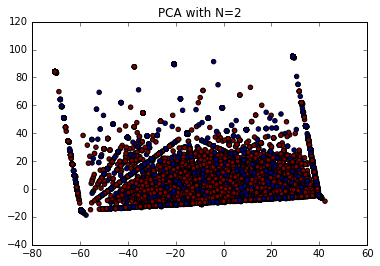

In [46]:
plt.scatter(reduced[:,0], reduced[:,1], c=labels)
plt.title("PCA with N=2")
plt.show()

That doesn't bode well.  Doesn't seem likely we'll be able to build a highly accurate classifier, but this can be deceiving; we're throwing away some information projecting the data into two dimensions. The explained variance report above implies we're capturing the vast majority of the variance, though, so not much hope for a decent classifier.  There are also some weird patterns here that imply some strange correlations and, to me, looks artificially generated.

An easy next step is to throw a bunch of classification techniques at it and see if we get lucky.  We'll again split into train and test sets, but this time using just the numerical fields.

In [16]:
data_train, data_test, labels_train, labels_test = train_test_split(just_numbers, labels, test_size=.25, random_state = 2008)

In [17]:
clf_svm = SVC().fit(data_train, labels_train)
print(clf_svm.score(data_test, labels_test))

0.74616


In [18]:
confusion_matrix(labels_test, clf_svm.predict(data_test))

array([[6797, 1115],
       [2058, 2530]])

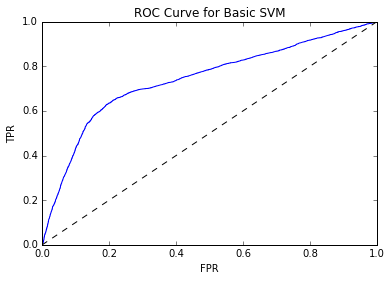

In [27]:
y_score = clf_svm.decision_function(data_test)
fpr, tpr, thresholds = roc_curve(labels_test, y_score)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve for Basic SVM")
plt.xlabel("FPR")
plt.ylabel("TPR")

This looks a lot better than our logistic classifier.  It's possible to compute the area under the curves (AUC) to reduce the comparison to a single number, but the shape of the curve is more important than the AUC; the point is to express the tradeoff between sensitivity and accuracy which can't be expressed in a single number.  Since it's rather misleading, I'll leave it out.  For example, we couldn't calculate the AUC for KNN, but we can see that KNN gives us the best tradeoff so far (time and memory constraints notwithstanding).

Before we move on to other classifiers, let's reduce our data some and feed *that* into our support vector machine.

0.74704


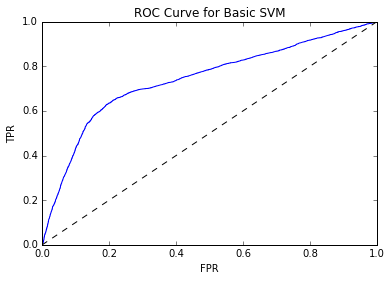

166.10823822021484


In [35]:
start = time.time()

pca_4 = PCA(n_components=4)
reduced_pca4 = pca_4.fit_transform(data_train)

clf_svm_pca4 = SVC().fit(reduced_pca4, labels_train)
data_test_pca4 = pca_4.transform(data_test)
print(clf_svm_pca4.score(data_test_pca4, labels_test))

y_score_pca4 = clf_svm_pca4.decision_function(data_test_pca4)
fpr_pca4, tpr_pca4, thresholds_pca4 = roc_curve(labels_test, y_score)

plt.plot(fpr_pca4, tpr_pca4)
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve for Basic SVM")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

end = time.time()
print(end - start)

The curve is suspiciously identical.  We'll leave PCA alone for now.

Let's try some other classifiers and see how they stack up.  Unfortunately, some other classifiers don't lend themselves to ROC curves, either because they're poor predictors of probability (like Naive Bayes) or because they don't deal in probabilities (like decision trees).  For now, we'll stick to accuracy.